Playing with Quantization Metrics:

Based on some metric of an image block (either saliency or from original image or DCT block or even filtered version of image) determine a 'level of compression' (ie. how much you'll quantize the image block) based on that metric.

For example, knowing that the standard deviation of an image region represents the image region's contrast, how can be adjust the quantization level of an image block based off of the standard deviation of that block. If it's high contrast, use lower quantization coefficient. If it's low contrast, use higher quantization coefficient.

In [80]:
import matplotlib.pyplot as plt
import cv2
import scipy
import ipywidgets as wdg
import skimage.io as skio
import skimage.util as skut
import skimage.color as skolor
import skimage.measure as skm
import skimage.transform as skitran
import skimage.exposure as ske
import skimage.filters as skif
import numpy as np

In [82]:
def collapse4D(blocks):
    """
    Converts 4D Block into 3D view block image by collapsing last two dimensions.

    Ex. Array with shape (64,64,8,8) transformed to (64,64,64)
    """
    return blocks.reshape(blocks.shape[0], blocks.shape[1], -1)

1. Methods for saliency map metric evaluations:

Section A: Methods for creating saliency map for an image, and calculating mean/standard deviation of luminance values across 8x8 blocks of that image

In [96]:
def create_saliency(img, mode = 'FG', convert = False):
    """
    Creates saliency map of image using cv2 Spectral Residual or Fine Grained
    Method (depending on mode parameter). Can convert to uint8 as well if
    convert parameter set to True. If no mode passed, Fine Grained used.

    returns saliency map
    """
    if mode == 'SR':
        saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
        (success, saliencyMap) = saliency.computeSaliency(img)
        if convert:
            saliencyMap = (saliencyMap * 255).astype("uint8")
        return saliencyMap
    elif mode == 'FG':
        saliency = cv2.saliency.StaticSaliencyFineGrained_create()
        (success, saliencyMap) = saliency.computeSaliency(img)
        if convert:
            saliencyMap = (saliencyMap * 255).astype("uint8")
        return saliencyMap
    
# Functions to calculate metrics from saliency maps, and hold in 8x8 blocks

def mean_saliency_block(salMap):
    """
    Calculates mean of saliency map luminance values in 8x8 blocks across image.
    """
    imsize = salMap.shape
    sal_mean = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            sal_mean[i:(i+8),j:(j+8)] = np.mean(salMap[i:(i+8), j:(j+8)])
    
    mean_blocks = skut.view_as_blocks(sal_mean, (8, 8))
    flat = collapse4D(mean_blocks)

    return flat

def std_saliency_block(salMap):
    """
    Calculates standard deviation of saliency map luminance values in 8x8 blocks across image.
    """
    imsize = salMap.shape
    sal_std = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            sal_std[i:(i+8),j:(j+8)] = np.std(salMap[i:(i+8), j:(j+8)])
    
    std_blocks = skut.view_as_blocks(sal_std, (8, 8))
    flat = collapse4D(std_blocks)

    return flat



Section B: Methods for viewing saliency map for an image, and viewing mean/standard deviation of luminance values across 8x8 blocks of that image

In [84]:
def view_saliency(salMap):
    """
    Creates saliency map of image using cv2 Spectral Residual or Fine Grained
    Method (depending on mode parameter). Can convert to uint8 as well if
    convert parameter set to True. If no mode passed, Fine Grained used.

    returns saliency map
    """
    plt.figure()
    plt.imshow(salMap, cmap='gray')
    plt.title( "8x8 blocks of image saliency map")

def view_mean_saliency(salMap):
    """
    Calculates mean of saliency map luminance values in 8x8 blocks across image.
    """
    imsize = salMap.shape
    sal_mean = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            sal_mean[i:(i+8),j:(j+8)] = np.mean(salMap[i:(i+8), j:(j+8)])
    
    plt.figure()
    plt.imshow(sal_mean, cmap='gray')
    plt.title( "Mean luminance value of 8x8 blocks of image saliency map")

def view_std_saliency(salMap):
    """
    Calculates standard deviation of saliency map luminance values in 8x8 blocks across image.
    """
    imsize = salMap.shape
    sal_std = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            sal_std[i:(i+8),j:(j+8)] = np.std(salMap[i:(i+8), j:(j+8)])
    
    plt.figure()
    plt.imshow(sal_std, cmap='gray')
    plt.title( "Standard Dev. of luminance values of 8x8 blocks of image saliency map")


2. Methods for DCT metric evaluations:

Section A: Methods for creating 8x8 block DCT map for an image, and calculating mean/standard deviation of luminance values across 8x8 blocks of that DCT array

In [95]:
# Functions to create and display 8x8 DCT blocks of image

def mean_dct(img, rToG = True):
    """
    Takes an image as input, converts to grayscale from RGB (unless rToG is False)
    And creates array which holds mean of DCT of image split into 8x8 blocks.
    """
    if rToG:
        img = skolor.rgb2gray(img)

    imsize = img.shape
    dct = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            dct[i:(i+8),j:(j+8)] = np.mean(scipy.fft.dctn(img[i:(i+8), j:(j+8)]))
    
    mean_dct_blocks = skut.view_as_blocks(dct, (8, 8))
    
    return collapse4D(mean_dct_blocks)


def std_dct(img, rToG = True):
    if rToG:
        img = skolor.rgb2gray(img)

    imsize = img.shape
    dct = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            dct[i:(i+8),j:(j+8)] = np.std(scipy.fft.dctn(img[i:(i+8), j:(j+8)]))
    
    std_dct_blocks = skut.view_as_blocks(dct, (8, 8))

    return collapse4D(std_dct_blocks)


Section B: Methods for visualizing 8x8 block DCT map for an image, and displaying mean/standard deviation of luminance values across 8x8 blocks of that DCT array

In [86]:
def dct_view(img, rToG = True):
    """
    Displays 8x8 block DCT view of an image. If rToG is not False, will assume original image is RGB
    and convert to grayscale.
    """
    if rToG:
        img = skolor.rgb2gray(img)
    
    imsize = img.shape
    dct = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            dct[i:(i+8),j:(j+8)] = scipy.fft.dctn(img[i:(i+8), j:(j+8)])

    plt.figure()
    plt.imshow(dct, cmap='gray',vmax= np.max(dct)*0.01, vmin = 0)
    plt.title( "8x8 DCT blocks of entire image")

def mean_dct_view(img, rToG = True):
    """
    Displays MEAN 8x8 block DCT view of an image. If rToG is not False, will assume original image is RGB
    and convert to grayscale.
    """
    if rToG:
        img = skolor.rgb2gray(img)

    imsize = img.shape
    mean_dct = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            mean_dct[i:(i+8),j:(j+8)] = np.mean(scipy.fft.dctn(img[i:(i+8), j:(j+8)]))

    plt.figure()
    plt.imshow(mean_dct, cmap='gray')
    plt.title("8x8 Mean DCT blocks of entire image")

def std_dct_view(img, rToG = True):
    """
    Displays STANDARD DEVIATION of 8x8 block DCT view of an image. If rToG is not False, will assume original image is RGB
    and convert to grayscale.
    """
    if rToG:
        img = skolor.rgb2gray(img)

    imsize = img.shape
    std_dct = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            std_dct[i:(i+8),j:(j+8)] = np.std(scipy.fft.dctn(img[i:(i+8), j:(j+8)]))

    plt.figure()
    plt.imshow(std_dct, cmap='gray')
    plt.title("8x8 Mean DCT blocks of entire image")


3. Using metrics of image with Laplacian of Gaussian Filter as basis for quantization evaluation

In [107]:
def create_LoG(img, sigma, rToG = True):
    if rToG:
        img = skolor.rgb2gray(img)
    
    return skif.difference_of_gaussians(img, sigma, channel_axis = -1)

def mean_log(LoG):
    imsize = LoG.shape
    mean_array = np.zeros(imsize)

    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            mean_array[i:(i+8),j:(j+8)] = np.mean(LoG[i:(i+8), j:(j+8)])
    
    mean_log_blocks = skut.view_as_blocks(mean_array, (8, 8))
    
    return collapse4D(mean_log_blocks)

def std_log(LoG):
    imsize = LoG.shape
    std_array = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            std_array[i:(i+8),j:(j+8)] = np.std(LoG[i:(i+8), j:(j+8)])
    
    std_log_blocks = skut.view_as_blocks(std_array, (8, 8))
    
    return collapse4D(std_log_blocks)


array([[[0.0168585 , 0.0168585 , 0.0168585 , ..., 0.0168585 ,
         0.0168585 , 0.0168585 ],
        [0.02180231, 0.02180231, 0.02180231, ..., 0.02180231,
         0.02180231, 0.02180231],
        [0.02149619, 0.02149619, 0.02149619, ..., 0.02149619,
         0.02149619, 0.02149619],
        ...,
        [0.01443843, 0.01443843, 0.01443843, ..., 0.01443843,
         0.01443843, 0.01443843],
        [0.01121006, 0.01121006, 0.01121006, ..., 0.01121006,
         0.01121006, 0.01121006],
        [0.01188136, 0.01188136, 0.01188136, ..., 0.01188136,
         0.01188136, 0.01188136]],

       [[0.02196185, 0.02196185, 0.02196185, ..., 0.02196185,
         0.02196185, 0.02196185],
        [0.01735222, 0.01735222, 0.01735222, ..., 0.01735222,
         0.01735222, 0.01735222],
        [0.02728034, 0.02728034, 0.02728034, ..., 0.02728034,
         0.02728034, 0.02728034],
        ...,
        [0.01583081, 0.01583081, 0.01583081, ..., 0.01583081,
         0.01583081, 0.01583081],
        [0.0

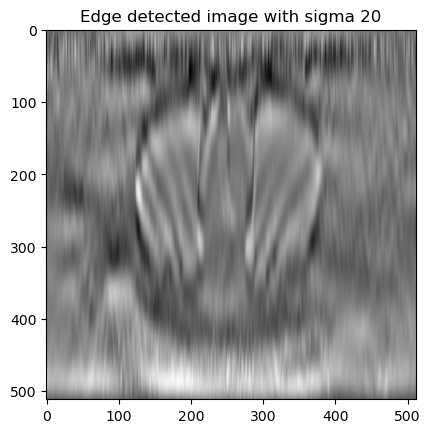

In [105]:
def LoG_view(img, sigma, rToG = True):
    """
    Displays 8x8 block LoG view of an image. If rToG is not False, will assume original image is RGB
    and convert to grayscale.
    """
    if rToG:
        img = skolor.rgb2gray(img)
    
    filtered = skif.difference_of_gaussians(img, sigma, channel_axis = -1)

    plt.figure()
    plt.imshow(filtered, cmap='gray')
    plt.title(f"Edge detected image with sigma {sigma}")

def mean_LoG_view(img, sigma, rToG = True):
    """
    Displays MEAN 8x8 block LoG view of an image. If rToG is not False, will assume original image is RGB
    and convert to grayscale.
    
    """
    LoG = create_LoG(img, sigma, rToG)

    imsize = LoG.shape
    mean_array = np.zeros(imsize)

    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            mean_array[i:(i+8),j:(j+8)] = np.mean(LoG[i:(i+8), j:(j+8)])

    plt.figure()
    plt.imshow(mean_array, cmap='gray')
    plt.title(f"8x8 mean blocks of image LoG with sigma = {sigma}")

def std_LoG_view(img, sigma, rToG = True):
    """
    Displays STANDARD DEVIATION of 8x8 block LoG view of an image. If rToG is not False, will assume original image is RGB
    and convert to grayscale.
    """
    LoG = create_LoG(img, sigma, rToG)

    imsize = LoG.shape
    std_array = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            std_array[i:(i+8),j:(j+8)] = np.std(LoG[i:(i+8), j:(j+8)])

    plt.figure()
    plt.imshow(std_array, cmap='gray')
    plt.title(f"8x8 standard deviation blocks of image LoG with sigma = {sigma}")
